# Importing Modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import librosa
from IPython.display import Audio

# Getting gender data from csv

In [2]:
df = pd.read_csv('cv-valid-train.csv')
df = df[~df['gender'].isna()]
df.shape

(74059, 8)

In [3]:
k = df[df['gender']=='male'].sample(n=1000)
k2 = df[df['gender']=='female'].sample(n=1000)
k.shape

(1000, 8)

In [4]:
final_data = pd.concat([k,k2]).sample(frac=1)
final_data.head()
# final_data.shape

,filename,text,up_votes,down_votes,age,gender,accent,duration
21530,cv-valid-train/sample-021530.mp3,i found it out a little late,1,0,thirties,female,us,NaN
84781,cv-valid-train/sample-084781.mp3,i think you're a great guy,1,0,thirties,male,england,NaN
172788,cv-valid-train/sample-172788.mp3,they continued across the desert,4,0,thirties,female,canada,NaN
184570,cv-valid-train/sample-184570.mp3,but there was a sixth day the sun went on,2,0,twenties,male,australia,NaN
168898,cv-valid-train/sample-168898.mp3,he had found where his treasure was and was fr...,7,1,twenties,female,us,NaN


# Feature Extraction from audio

In [5]:
BASE_DIR = 'cv-valid-train/'
X_train,y_train=[],[]
for i in tqdm(final_data.index):
    file = BASE_DIR + final_data.loc[i,'filename']
    wf, sr = librosa.load(file)
    mfcc_wf = librosa.feature.mfcc(y=wf,sr=sr)
    b = tf.keras.utils.pad_sequences(mfcc_wf,padding='post',maxlen=200)
    X_train.append(b)
    if final_data.loc[i,'gender'] == 'male':
        y_train.append(1)
    else:
        y_train.append(0)

100%|██████████| 2000/2000 [00:36<00:00, 54.80it/s]


In [6]:
X_train = np.array(X_train)
X_train.shape

(2000, 20, 200)

In [7]:
y_train = np.array(y_train)
y_train.shape

(2000,)

# Model Building

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(20,200,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 256)               1024256   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1065473 (4.06 MB)
Trainable params: 1065473 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=64,validation_split=0.2)


Epoch 1/64


50/50 [==============================] - 2s 20ms/step - loss: 13.2702 - accuracy: 0.6538 - val_loss: 7.1557 - val_accuracy: 0.7050
Epoch 2/64
50/50 [==============================] - 1s 12ms/step - loss: 6.8535 - accuracy: 0.7606 - val_loss: 6.5907 - val_accuracy: 0.7575
Epoch 3/64
50/50 [==============================] - 1s 12ms/step - loss: 5.2358 - accuracy: 0.8331 - val_loss: 5.7539 - val_accuracy: 0.7650
Epoch 4/64
50/50 [==============================] - 1s 11ms/step - loss: 4.2088 - accuracy: 0.8888 - val_loss: 4.4806 - val_accuracy: 0.7875
Epoch 5/64
50/50 [==============================] - 1s 12ms/step - loss: 3.6412 - accuracy: 0.9156 - val_loss: 4.3384 - val_accuracy: 0.7875
Epoch 6/64
50/50 [==============================] - 1s 12ms/step - loss: 3.4759 - accuracy: 0.8825 - val_loss: 3.8209 - val_accuracy: 0.8000
Epoch 7/64
50/50 [==============================] - 1s 12ms/step - loss: 2.8656 - accuracy: 0.9594 - val_loss: 3.8994 - val_accuracy: 0.7775
Epoch 8/6

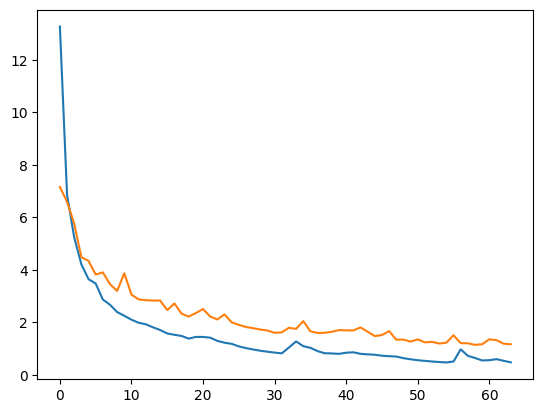

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [11]:
from sklearn.metrics import classification_report

In [12]:
y_pred = model.predict(X_train)
y_pred.reshape(-1)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
y_pred = np.array(y_pred)
y_train.reshape((2000,1))
rep = classification_report(y_train,y_pred)

63/63 [==============================] - 0s 2ms/step


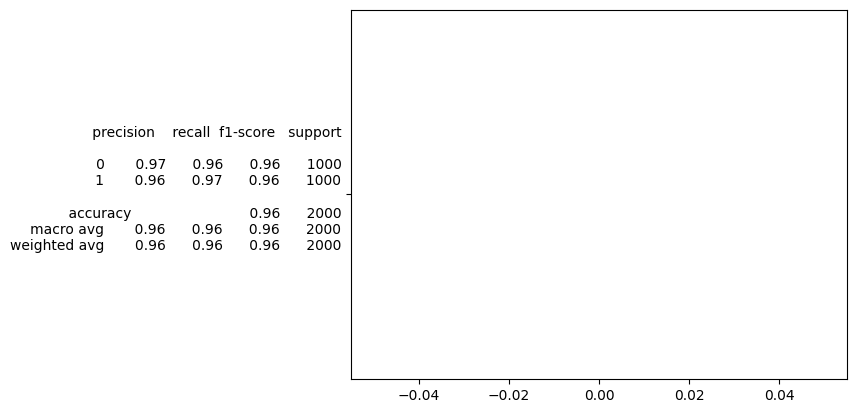

In [13]:
plt.plot(rep)

# Prediction from Audio

In [14]:
wf, sr = librosa.load('cv-valid-test/cv-valid-test/sample-000015.mp3')
mfcc_wf = librosa.feature.mfcc(y=wf,sr=sr)
b = tf.keras.utils.pad_sequences(mfcc_wf,padding='post',maxlen=200)
model.predict(np.array([b]))

1/1 [==============================] - 0s 31ms/step


array([[0.45691365]], dtype=float32)

In [15]:
model.save('Model')

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


In [16]:
!zip -r 'model.zip' 'Model'

'zip' is not recognized as an internal or external command,
operable program or batch file.
